# Comparison of GNNs for top-N recommendation on MovieLens

This is a group project for the UT Network Science course spring 2023.

**Dataset**

We use the MovieLens 25M dataset from which we create different subsamples for experimentation purposes. We experiment how the dataset size and data pruning accent the model performance.

We experiment with the following subsamples:
1. Only reviews from the years 2018-2019 of which we take a random sample of 1000 users. No data pruning. This sample is in the file 'ratings_subsample_120K.csv'
2. Same sample as 1. but with added data pruning: ...
3. ... larger sample no pruning ...
4. ... larger sample with pruning ...

**Data splitting**
We test three different data splitting strategies:
1. Random splitting - the edges are split randomly into train, test and val according to a defined ratio. The timestamps are not considered.
2. Temporal splitting - the edges are split using splitpoints of two specific timestamps. Train edges are the 'past', test edges are the 'future.
3. Leave one edge out splitting - edges are split considering the edge timestamps of specific users. For each user, the latest review is the test edge.

**Models**

We compare the performance of these models for the top-N recommendation task:
- LightGCN
- model 2
- model 3

**Metrics**

As performance metrics we use:
- Recall@K
- Precision@K
- NDCG@K

## Installing and importing libraries

In [1]:
import torch
from torch import Tensor
print(torch.__version__)

2.0.0+cu118


In [2]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 53.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 51.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/nightly/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-gig7z9b7
  Running command git clone --filter=blob:none --quiet https://githu

In [3]:
pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=035e0518c332f985d461143221ac69829aea28cdc9b234fc822d84df53a76c0a
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [4]:
# Import libraries
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch import nn, optim

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

from sentence_transformers import SentenceTransformer

import networkx as nx

# Data

## Loading the data

We have already done the data sampling (see notebook 'subsample_creation.ipynb'). The subsample is in the 'data' folder. In addition, make sure you have the enriched movies information (files 'movie_ml_imdb.csv' and 'nconst_info.csv') placed in the 'data' folder. If not, download them [HERE](https://drive.google.com/file/d/1fz8WjLy0_UYioFbMirYrjhM00EYnCaWP/view?usp=sharing).

In [8]:
# Rating data
rating_path = './data/ratings_subsample_120K.csv'
ratings = pd.read_csv(rating_path)

In [9]:
# Movies data with genre, year and additional features such as director, writer, actor, actress, producer etc
movies_path = './data/movie_ml_imdb.csv'
nconst_info_path = './data/nconst_info.csv'
movies = pd.read_csv(movies_path, sep='\t')
nconst_info = pd.read_csv(nconst_info_path, sep='\t')

In [10]:
# From the ratings info, we will use userId, moveId, rating and timestamp (for temporal data splitting purposes)
ratings.head()

,userId,movieId,rating,timestamp,year,month
0,114,19,3.5,2019-08-03 09:16:07,2019,8
1,114,296,5.0,2019-08-03 08:55:04,2019,8
2,114,344,3.5,2019-08-03 09:09:09,2019,8
3,114,480,3.5,2019-08-23 17:58:25,2019,8
4,114,541,3.0,2018-12-22 20:10:39,2018,12


In [11]:
# From movies info, we will use movieId and have 8 movie node features: genre, title, year, actor, actress, director, producer, writer
movies.columns

Index(['movieId', 'title', 'genres_ml', 'year', 'tconst', 'writer', 'actor',
       'director', 'producer', 'actress', 'cinematographer', 'composer',
       'editor', 'production_designer', 'archive_footage', 'archive_sound',
       'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear',
       'endYear', 'runtimeMinutes', 'genres_imdb', 'directors', 'writers'],
      dtype='object')

In [12]:
# Keep only the columns of interest to us
movies = movies[['movieId', 'title', 'genres_ml', 'year', 'actor', 'actress', 'director', 'producer', 'writer']]

# Replace \N
movies = movies.replace(r'\\N',  'Unknown', regex=True)

# Keep only movies that are in the subsample
movies_in_ratings = ratings.movieId.unique()
movies = movies[movies.movieId.isin(movies_in_ratings)]

# Rename genres
movies = movies.rename(columns={"genres_ml": "genre"})

In [13]:
ratings

,userId,movieId,rating,timestamp,year,month
0,114,19,3.5,2019-08-03 09:16:07,2019,8
1,114,296,5.0,2019-08-03 08:55:04,2019,8
2,114,344,3.5,2019-08-03 09:09:09,2019,8
3,114,480,3.5,2019-08-23 17:58:25,2019,8
4,114,541,3.0,2018-12-22 20:10:39,2018,12
...,...,...,...,...,...,...
126682,162190,122916,1.5,2019-11-15 13:19:50,2019,11
126683,162190,164179,3.5,2019-11-15 13:24:02,2019,11
126684,162190,194448,4.0,2019-11-15 13:20:50,2019,11
126685,162190,195159,1.0,2019-11-15 13:20:37,2019,11


In [14]:
nconst_info_dict = dict(zip(nconst_info.index,nconst_info.primaryName)) # For later mapping of director, actor etc ids to their names

In [15]:
movies.head()

,movieId,title,genre,year,actor,actress,director,producer,writer
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,nm0000158|nm0000741|nm0725543|nm0001815,Unknown,nm0005124,Unknown,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736
1,2,Jumanji,Adventure|Children|Fantasy,1995,nm0000245|nm0404993,nm0000379|nm0001372,nm0002653,nm0472256,nm0378144|nm0852430|nm0833164|nm0885575
2,3,Grumpier Old Men,Comedy|Romance,1995,nm0000527|nm0000493,nm0000268|nm0000047,nm0222043,nm0075828|nm0204862,nm0425756
4,5,Father of the Bride Part II,Comedy,1995,nm0000188|nm0001737,nm0000473|nm0931090,nm0796124,Unknown,nm0352443|nm0329304|nm0583600
5,6,Heat,Action|Crime|Thriller,1995,nm0000199|nm0000134|nm0000174|nm0000685,Unknown,nm0000520,nm0513165,Unknown


## Graph properties and descriptive analysis using NetworkX

In [16]:
ratings_only_pos = ratings[ratings.rating >=4] # Hetkel jätame GNN-i jaoks ainult positiivsed ratingud, vt all load_edges
graph = nx.from_pandas_edgelist(ratings_only_pos, source='userId', target='movieId', create_using=nx.DiGraph())

In [17]:
#nx.draw(graph)

In [18]:
# TO DO

# Lisada networkx v2rki

## PyTorch Geometric: loading nodes, edges, encoding features

Before we can train a GNN on this graph, we must prepare the data accordingly.

In [19]:
def load_nodes(df, index_col, encoders=None):
    df_reset = df.set_index(index_col)

    mapping = {index: i for i, index in enumerate(df_reset.index.unique())}

    x = None
    if encoders is not None:
        xs = [encoder(df_reset[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

In [20]:
def load_edges(df, src_index_col, src_mapping, dst_index_col, dst_mapping, remove_neg_ratings=True):

    # So we can do the split by global timeline later
    df = df.sort_values('timestamp')

    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]

    edge_timestamp = df.timestamp.values

    if remove_neg_ratings == True:
        # Jätab alles ainult positiivsed ratingud.
        # Ala nagu siin: https://colab.research.google.com/drive/1KKugoFyUdydYC0XRyddcROzfQdMwDcnO?usp=sharing#scrollTo=5OBSacx6Q03m
        edge_attr = torch.from_numpy(ratings.rating.values).view(-1, 1).to(torch.long) >= 4

        # Leave only edges with positive ratings
        edge_index = [[], []]
        for i in range(edge_attr.shape[0]):
            if edge_attr[i]:
                edge_index[0].append(src[i])
                edge_index[1].append(dst[i])

        edge_index = torch.tensor(edge_index)

        # Accordingly leave only timestamps of the positive ratings
        edge_timestamp = edge_timestamp[edge_attr.reshape(-1)]

    else:
        # Nii arvestab kõiki ratinguid ja neid saaks kasutada nagu label-eid, siis oleks rating prediction task
        edge_attr = torch.from_numpy(df.rating.values).view(-1, 1).to(torch.long)
        edge_index = torch.tensor([src, dst])

    return edge_index, edge_attr, edge_timestamp

In [21]:
# Encoder for movie title
class SequenceEncoder:
    # The 'SequenceEncoder' encodes raw column strings into embeddings.
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(df.values, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
        return x.cpu()

In [22]:
# Encoder for other movie features
class CategoryEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        categories = set(c for col in df.values for c in col.split(self.sep))
        mapping = {category: i for i, category in enumerate(categories)}

        x = torch.zeros(len(df), len(mapping))

        for i, col in enumerate(df.values):
            for category in col.split(self.sep):
                x[i, mapping[category]] = 1
        return x

In [23]:
user_x, user_mapping = load_nodes(ratings, index_col='userId')

In [24]:
movie_x, movie_mapping = load_nodes(movies,
                                    index_col='movieId',
                                    encoders={'title': SequenceEncoder(), # Teeme kõik movie node feature-iteks. Alternatiiv oleks need teha eraldi node-ideks
                                              'genre': CategoryEncoder(),
                                              'year': CategoryEncoder(),
                                              'actor': CategoryEncoder(),
                                              'actress': CategoryEncoder(),
                                              'director': CategoryEncoder(),
                                              'producer': CategoryEncoder(),
                                              'writer': CategoryEncoder()})

Batches:   0%|          | 0/428 [00:00<?, ?it/s]

In [25]:
edge_index, edge_attr, edge_timestamp = load_edges(
    ratings,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='movieId',
    dst_mapping=movie_mapping
)

In [26]:
print('Number of edges: ', edge_index.shape[1])

Number of edges:  62738


## Train-val-test split and mini-batching functions

Kaaluda, kas t6sta eraldi faili.

In [28]:
# Because edges are sorted by the timestamp (see the load_edges function), we can easily do a train-val-test split based on the global timeline.
edge_timestamp

array(['2018-01-01 01:14:17', '2018-01-01 01:22:28',
       '2018-01-01 01:28:29', ..., '2019-11-20 22:17:19',
       '2019-11-20 22:19:35', '2019-11-21 01:47:00'], dtype=object)

In [250]:
# train/validation/test split
# Funktisooni saaks ka t2iendada, et nt valida ratio-t
def train_val_test_split(edge_index, split_strategy='temporal'):
  num_interactions = edge_index.shape[1]

  # split by global timepoint, there is no data leakage
  # 80/10/10 ratio 
  if split_strategy == 'temporal':
    train_edge_index = edge_index[:,np.arange(0,num_interactions*0.8)]
    val_edge_index = edge_index[:,np.arange(num_interactions*0.8,num_interactions*0.9)]
    test_edge_index = edge_index[:,np.arange(num_interactions*0.9,num_interactions)]

  # Random split by interactions ratio, there is data leakage
  # 80/10/10 ratio
  elif split_strategy == 'random':
    all_indices = [i for i in range(num_interactions)]

    train_indices, test_indices = train_test_split(
        all_indices, test_size=0.2, random_state=1)
    val_indices, test_indices = train_test_split(
        test_indices, test_size=0.5, random_state=1)

    train_edge_index = edge_index[:, train_indices]
    val_edge_index = edge_index[:, val_indices]
    test_edge_index = edge_index[:, test_indices]

  # Leave-one-out strategy, there is data leakage
  # Leave the latest interaction for test, one before the latest for valid, rest for train
  # NB proportsioonid tulevad teised (mitte 80/10/10), kuna siin pole ratio j2rgi split, vaid userite kaupa
  elif split_strategy == 'leave_one_out':
    unique_ids = np.unique(edge_index[0].cpu().numpy())
    edges = edge_index.cpu().numpy()
    train_edge_index = [[],[]]
    val_edge_index = [[],[]]
    test_edge_index = [[],[]]

    for id in unique_ids:
      user_edges = np.vstack((edges[0][edges[0]==id], edges[1][edges[0]==id]))

      # Check the number of interactions for each user, if it is less than three, then only treat the interaction as train or train and val
      if len(user_edges[0])==1:
        train_edge_index = np.concatenate((train_edge_index,user_edges),axis=1).astype(int)

      elif len(user_edges[0])==2:
        train_edge_index = np.concatenate((train_edge_index,user_edges[:,:-1]),axis=1).astype(int)
        test_edge_index = np.concatenate((test_edge_index,user_edges[:,-1].reshape(-1,1)),axis=1).astype(int)

      else:    
        test_edge_index = np.concatenate((test_edge_index,user_edges[:,-1].reshape(-1,1)),axis=1).astype(int)
        val_edge_index = np.concatenate((val_edge_index,user_edges[:,-2].reshape(-1,1)),axis=1).astype(int)
        train_edge_index = np.concatenate((train_edge_index,user_edges[:,:-2]),axis=1).astype(int)

    train_edge_index = torch.tensor(train_edge_index)
    test_edge_index = torch.tensor(test_edge_index)
    val_edge_index = torch.tensor(val_edge_index)


  return train_edge_index, val_edge_index, test_edge_index



In [34]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# LightGCN and evaluation functions
 
 to-do: tutvustav jutt lightGCN-i kohta ja kirjeldus selle kohta, kuidas mudelit kasutame.

 **Kaaluda, kas tõsta kõik need pikad funktsioonid eraldi faili ja jätta siia ainult eksperimendid**

In [35]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)


In [36]:
# Bayesian Personalized Ranking (BPR) loss is a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

In [37]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [38]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [39]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [40]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [41]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

# Experiment 1: LightGCN, random split, dataset sample 1000 users without pruning

In [267]:
# To observe the effect the data splitting strategy has, we also test the random split strategy
train_edge_index, val_edge_index, test_edge_index = train_val_test_split(edge_index, 'random')

num_edges_in_train = train_edge_index.shape[1]
num_edges_in_val = val_edge_index.shape[1]
num_edges_in_test = test_edge_index.shape[1]

print('Num edges in training set: ', num_edges_in_train)
print('Num edges in validation set: ', num_edges_in_val)
print('Num edges in test set: ', num_edges_in_test)

Num edges in training set:  50190
Num edges in validation set:  6274
Num edges in test set:  6274


In [79]:
num_users = len(train_edge_index[0].unique())
num_movies = len(train_edge_index[1].unique())
num_users, num_movies # considering only positive edges
num_users, num_movies = len(user_mapping), len(movie_mapping) # considering all edges

(967, 8683)

In [33]:
from torch_sparse import SparseTensor, matmul
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))

In [ ]:
model = LightGCN(num_users, num_movies)

In [42]:
# define contants
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [43]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


In [44]:
# training loop
train_losses = []
val_losses = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.69118, val_loss: -0.68111, val_recall@20: 0.00091, val_precision@20: 0.00049, val_ndcg@20: 0.00058
[Iteration 200/10000] train_loss: -0.69615, val_loss: -0.68349, val_recall@20: 0.01325, val_precision@20: 0.00451, val_ndcg@20: 0.00993
[Iteration 400/10000] train_loss: -0.80363, val_loss: -0.73515, val_recall@20: 0.08983, val_precision@20: 0.0234, val_ndcg@20: 0.05642
[Iteration 600/10000] train_loss: -1.44081, val_loss: -1.07671, val_recall@20: 0.09026, val_precision@20: 0.02444, val_ndcg@20: 0.05714
[Iteration 800/10000] train_loss: -2.83814, val_loss: -1.90741, val_recall@20: 0.09104, val_precision@20: 0.02469, val_ndcg@20: 0.05683
[Iteration 1000/10000] train_loss: -4.52256, val_loss: -3.04518, val_recall@20: 0.09135, val_precision@20: 0.02469, val_ndcg@20: 0.05692
[Iteration 1200/10000] train_loss: -6.46081, val_loss: -4.27381, val_recall@20: 0.09181, val_precision@20: 0.02531, val_ndcg@20: 0.05794
[Iteration 1400/10000] train_loss: -8.65188, val_

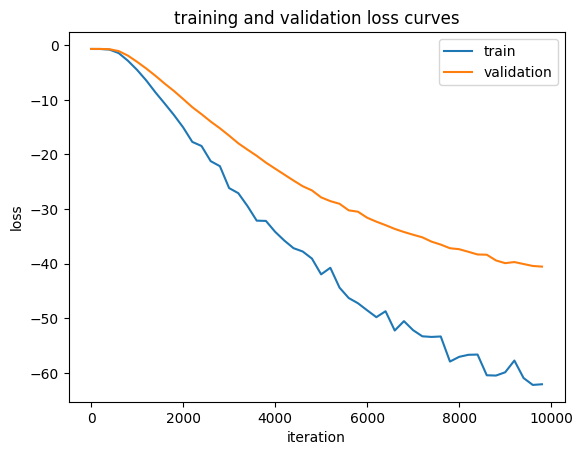

In [45]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [46]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -39.62844, test_recall@20: 0.10312, test_precision@20: 0.02674, test_ndcg@20: 0.06628


# Experiment 2: LightGCN, split by global timeline, dataset sample 1000 users without pruning

In [266]:
# We split the edges of the graph using a 80/10/10 train/validation/test split based on the global timeline.
print(f'Training set is from {edge_timestamp[0]} to {edge_timestamp[int(len(edge_timestamp)*0.8)-1]}.')
print(f'Validation set is from {edge_timestamp[int(len(edge_timestamp)*0.8)]} to {edge_timestamp[int(len(edge_timestamp)*0.9)-1]}.')
print(f'Test set is from {edge_timestamp[int(len(edge_timestamp)*0.9)]} to {edge_timestamp[-1]}.')
print()

train_edge_index, val_edge_index, test_edge_index = train_val_test_split(edge_index, 'temporal')

num_edges_in_train_2 = train_edge_index.shape[1]
num_edges_in_val_2 = val_edge_index.shape[1]
num_edges_in_test_2 = test_edge_index.shape[1]

print('Num edges in training set: ', num_edges_in_train_2)
print('Num edges in validation set: ', num_edges_in_val_2)
print('Num edges in test set: ', num_edges_in_test_2)

Training set is from 2018-01-01 01:14:17 to 2019-06-01 11:44:42.
Validation set is from 2019-06-01 11:44:58 to 2019-08-18 05:17:34.
Test set is from 2019-08-18 05:18:27 to 2019-11-21 01:47:00.

Num edges in training set:  50191
Num edges in validation set:  6274
Num edges in test set:  6274


In [80]:
num_users = len(train_edge_index[0].unique())
num_movies = len(train_edge_index[1].unique())
num_users, num_movies # Number of users and movies after maintaining only positive ratings (see load edges method)
num_users, num_movies = len(user_mapping), len(movie_mapping) # considering all edges

(967, 8683)

In [54]:
from torch_sparse import SparseTensor, matmul
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))

In [55]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

model_2 = LightGCN(num_users, num_movies)
model_2 = model_2.to(device)
model_2.train()

optimizer = optim.Adam(model_2.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


In [57]:
# training loop
train_losses_2 = []
val_losses_2 = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model_2.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model_2.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model_2, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses_2.append(train_loss.item())
        val_losses_2.append(val_loss)
        model_2.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.69118, val_loss: -0.68118, val_recall@20: 0.00086, val_precision@20: 0.00068, val_ndcg@20: 0.0009
[Iteration 200/10000] train_loss: -0.69612, val_loss: -0.68178, val_recall@20: 0.00986, val_precision@20: 0.00338, val_ndcg@20: 0.00583
[Iteration 400/10000] train_loss: -0.80014, val_loss: -0.68393, val_recall@20: 0.01883, val_precision@20: 0.01396, val_ndcg@20: 0.02007
[Iteration 600/10000] train_loss: -1.37851, val_loss: -0.71544, val_recall@20: 0.02265, val_precision@20: 0.02095, val_ndcg@20: 0.0269
[Iteration 800/10000] train_loss: -2.69615, val_loss: -0.81226, val_recall@20: 0.02376, val_precision@20: 0.0241, val_ndcg@20: 0.03032
[Iteration 1000/10000] train_loss: -4.41582, val_loss: -0.97691, val_recall@20: 0.02575, val_precision@20: 0.0268, val_ndcg@20: 0.03241
[Iteration 1200/10000] train_loss: -6.31796, val_loss: -1.20149, val_recall@20: 0.02658, val_precision@20: 0.0277, val_ndcg@20: 0.03403
[Iteration 1400/10000] train_loss: -8.29961, val_loss

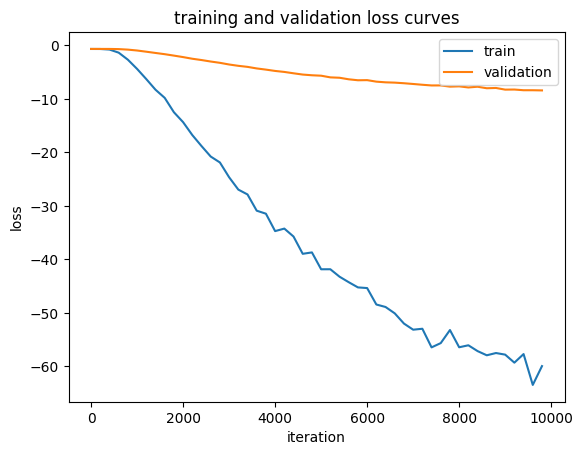

In [58]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses_2))]
plt.plot(iters, train_losses_2, label='train')
plt.plot(iters, val_losses_2, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [59]:
# evaluate on test set
model_2.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss_2, test_recall_2, test_precision_2, test_ndcg_2 = evaluation(
            model_2, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss_2, 5)}, test_recall@{K}: {round(test_recall_2, 5)}, test_precision@{K}: {round(test_precision_2, 5)}, test_ndcg@{K}: {round(test_ndcg_2, 5)}")

[test_loss: -6.24077, test_recall@20: 0.02788, test_precision@20: 0.03506, test_ndcg@20: 0.04288


# Experiment 3: LightGCN, leave one edge out split, dataset sample 1000 users without pruning

In [265]:
# To observe the effect the data splitting strategy has, we also test the random split strategy
train_edge_index, val_edge_index, test_edge_index = train_val_test_split(edge_index, 'leave_one_out')

num_edges_in_train_3 = train_edge_index.shape[1]
num_edges_in_val_3 = val_edge_index.shape[1]
num_edges_in_test_3 = test_edge_index.shape[1]

print('Num edges in training set: ', num_edges_in_train_3)
print('Num edges in validation set: ', num_edges_in_val_3)
print('Num edges in test set: ', num_edges_in_test_3)

Num edges in training set:  60852
Num edges in validation set:  935
Num edges in test set:  951


In [256]:
num_users, num_movies = len(user_mapping), len(movie_mapping) # total users and movies

In [257]:
from torch_sparse import SparseTensor, matmul
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))

In [272]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

model_3 = LightGCN(num_users, num_movies)
model_3 = model_3.to(device)
model_3.train()

optimizer = optim.Adam(model_3.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


In [273]:
# training loop
train_losses_3 = []
val_losses_3 = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model_3.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model_3.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model_3, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses_3.append(train_loss.item())
        val_losses_3.append(val_loss)
        model_3.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.69122, val_loss: -0.68102, val_recall@20: 0.00184, val_precision@20: 0.00086, val_ndcg@20: 0.00166
[Iteration 200/10000] train_loss: -0.69845, val_loss: -0.68352, val_recall@20: 0.02318, val_precision@20: 0.00778, val_ndcg@20: 0.01599
[Iteration 400/10000] train_loss: -0.85801, val_loss: -0.7415, val_recall@20: 0.08321, val_precision@20: 0.02395, val_ndcg@20: 0.05247
[Iteration 600/10000] train_loss: -1.65482, val_loss: -1.09659, val_recall@20: 0.0843, val_precision@20: 0.02537, val_ndcg@20: 0.05515
[Iteration 800/10000] train_loss: -3.24679, val_loss: -1.85398, val_recall@20: 0.08978, val_precision@20: 0.025, val_ndcg@20: 0.05603
[Iteration 1000/10000] train_loss: -5.21323, val_loss: -2.84234, val_recall@20: 0.09146, val_precision@20: 0.02512, val_ndcg@20: 0.05797
[Iteration 1200/10000] train_loss: -7.26375, val_loss: -3.96748, val_recall@20: 0.09074, val_precision@20: 0.02531, val_ndcg@20: 0.05762
[Iteration 1400/10000] train_loss: -9.25773, val_los

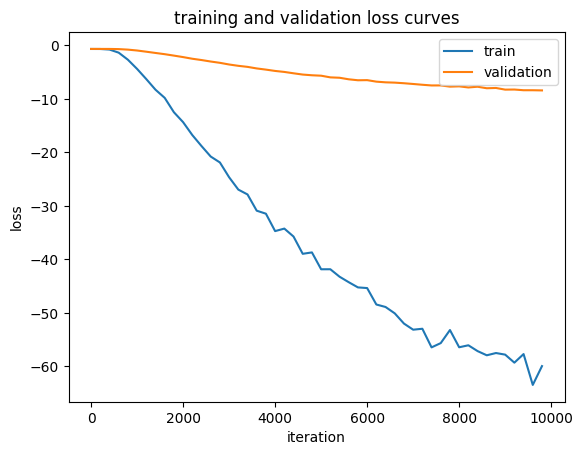

In [274]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses_3))]
plt.plot(iters, train_losses_2, label='train')
plt.plot(iters, val_losses_2, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [275]:
# evaluate on test set
model_3.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss_3, test_recall_3, test_precision_3, test_ndcg_3 = evaluation(
            model_3, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss_3, 5)}, test_recall@{K}: {round(test_recall_3, 5)}, test_precision@{K}: {round(test_precision_3, 5)}, test_ndcg@{K}: {round(test_ndcg_3, 5)}")

[test_loss: -33.59192, test_recall@20: 0.10376, test_precision@20: 0.02729, test_ndcg@20: 0.06675


# Comparison

In [276]:
num_users, num_movies = len(user_mapping), len(movie_mapping) # total users and movies
unique_uids = len(np.unique(edge_index[0].cpu().numpy())) # total users who have positive reviews
unique_iids = len(np.unique(edge_index[1].cpu().numpy())) # total movies which have positive reviews
edges_total = len(edge_index[1].cpu().numpy()) # total edges

comparison_data = {'model': ['LightGCN','LightGCN','LightGCN'],
                   'split_strategy':['random','temporal','leave_one_out'],
                   'edges_in_train':[num_edges_in_train, num_edges_in_train_2,num_edges_in_train_3],
                   'edges_in_val':[num_edges_in_val, num_edges_in_val_2, num_edges_in_val_3],
                   'edges_in_test':[num_edges_in_test, num_edges_in_test_2,num_edges_in_test_3], 
                   'test_recall@K':[test_recall,test_recall_2,test_recall_3], 
                   'test_precision@K':[test_precision,test_precision_2,test_precision_3],
                   'test_ndcg@K':[test_ndcg, test_ndcg_2,test_ndcg_3],
                   'K':[K,K,K]}

In [277]:
df_comparison = pd.DataFrame(data=comparison_data) # Results

In [278]:
print('Experiments stats:')
print('Total users:', num_users)
print('Total users with at least one positive edge:', unique_uids)
print('Total movies:', num_movies)
print('Total movies with at least one positive edge:', unique_iids)
print('Total edges (positive reviews):',edges_total)

df_comparison.transpose()

Experiments stats:
Total users: 1000
Total users with at least one positive edge: 976
Total movies: 13694
Total movies with at least one positive edge: 9668
Total edges (positive reviews): 62738


,0,1,2
model,LightGCN,LightGCN,LightGCN
split_strategy,random,temporal,leave_one_out
edges_in_train,50190,50191,60852
edges_in_val,6274,6274,935
edges_in_test,6274,6274,951
test_recall@K,0.103121,0.027877,0.10376
test_precision@K,0.026744,0.035062,0.027295
test_ndcg@K,0.066275,0.042876,0.06675
K,20,20,20


# Model 2

In [47]:
# to do

# Model 3

In [48]:
# to do

# Comparison of the models

In [50]:
# to do

# GNN explainability

In [51]:
# to do

# References

Our code is inspired by these tutorials:
- https://colab.research.google.com/drive/1VfP6JlWbX_AJnx88yN1tM3BYE6XAADiy?usp=sharing 
- https://colab.research.google.com/drive/1KKugoFyUdydYC0XRyddcROzfQdMwDcnO?usp=sharing&fbclid=IwAR1-1pncUhTk5HZ8tP74e6thaK2gBaTD0FX7uqABTzE_-OLSLpSaUBOq0mA
- https://colab.research.google.com/drive/1xpzn1Nvai1ygd_P5Yambc_oe4VBPK_ZT?usp=sharing&fbclid=IwAR1jsKGQhpdRrM22Fgg5ljTa4x1c4epqlTPsgou_2mIo6rBmjnLY1q8TmMU#scrollTo=D6ixkcCOwCDi
- https://github.com/gusye1234/LightGCN-PyTorch
- https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch
- https://pytorch-geometric.readthedocs.io/en/latest/notes/load_csv.html